# MBTI Project

By The Introverts 

#  For saving time, find and run step1,2,3 before modeling:

In [1]:
reset -fs

In [2]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import re
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import numpy as np
plt.style.use('fivethirtyeight')

In [3]:
mbti = pd.read_csv('data/mbti_1.csv') 

## General info:
#### Personality Types:

First, we take a look at distribution of the MBTI personality types

<BarContainer object of 16 artists>

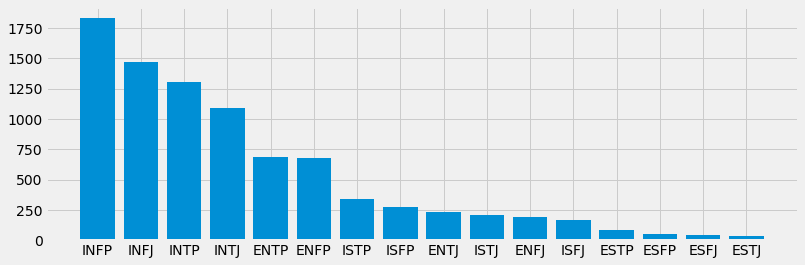

In [6]:
stat = mbti['type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(stat.index,stat.values)

4 capitals' meaning:
- extroversion vs. introversion 
- intuition vs. sensing
- thinking vs. feeling
- judging vs. perceiving

In [7]:
# Types per category
# analyze types by sub-category may be easier
mbti['EorI']= mbti['type'].apply(lambda x:x[0])
mbti['NorS']= mbti['type'].apply(lambda x:x[1])
mbti['TorF']= mbti['type'].apply(lambda x:x[2])
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

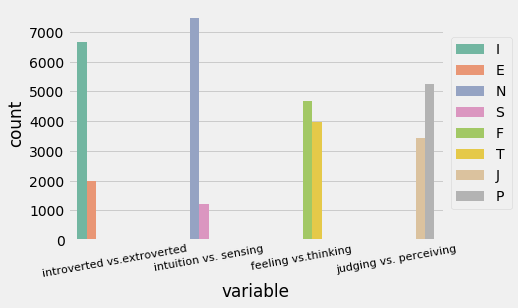

In [8]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Imbalanced class: I vs E, N vs S. Some advanced techniques like resampling methods may be needed later to handle imbalanced classes.

#### Their last 50 posts:
Focus on some statistics(mean,variance) of posts

words they averagely used in per comment

In [9]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [10]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576


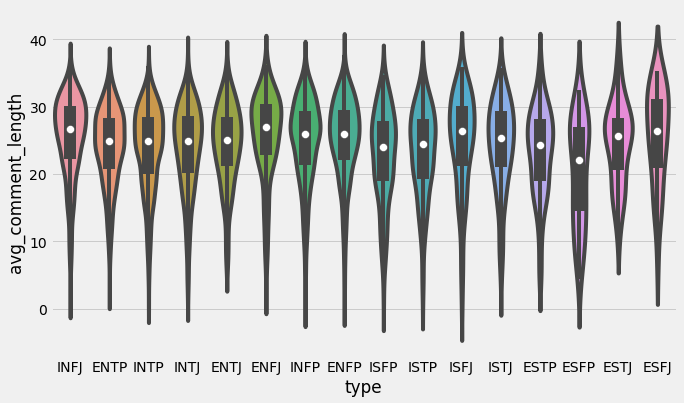

In [11]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='avg_comment_length', data=mbti)

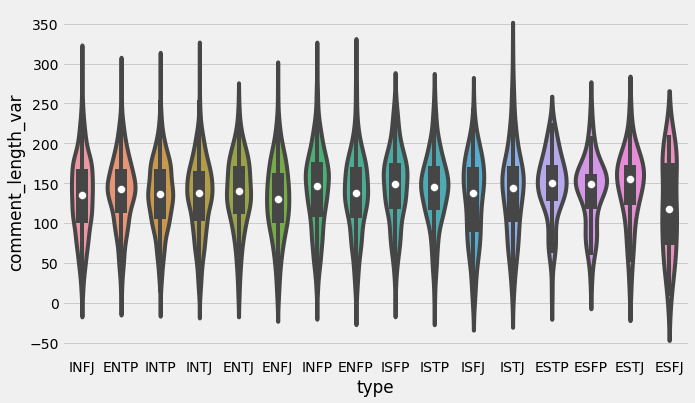

In [12]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='comment_length_var', data=mbti)

## Data preprocessing

### Define a function for cleaning the posts:
- Remove "|||" and links and punctuations and MBTI words(As u see in the text, real names user referring to are changed to MBTI type)
- Lowercase
- Lemmatize word, remove stop words and words less than 3 characters (lemmatizing would be better than stemming but takes more time)

In [13]:
# get 16 types of personality list for removing MBTI words in the following function
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]

In [14]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer() # or use PorterStemmer(), if want to run faster
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        # clean the posts
        posts = row[1].posts
        posts = re.sub(r'\|\|\|',' ',posts)
        posts = re.sub(r'http[\S]*', '', posts).lower()
        posts = re.sub("[^a-z\s]", ' ', posts)
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        for t in types:
            posts = posts.replace(t,'')
        post_list.append(posts)
        
    return np.array(post_list)      

In [15]:
# Here I takes 15mins to run it T_T
#processed_post = post_preprocess(mbti)

# Step1

In [4]:
# save time, run this to load the clean post
processed_post = pd.read_csv('data/mbti_preprocessed_1.csv')
processed_post.drop('Unnamed: 0',axis=1,inplace=True)
processed_post.head()

,type,posts,processed_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


### Word Cloud

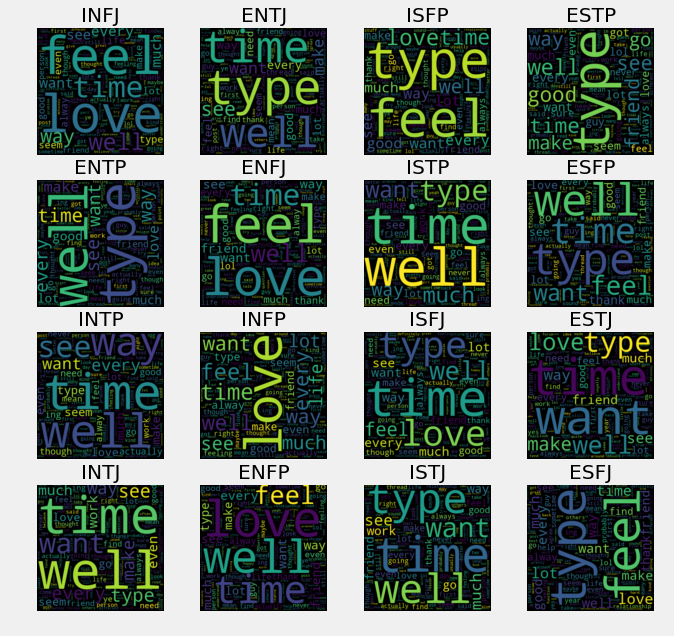

In [29]:
# u can skip this cell. Don't run it!
dim = int(len(processed_post['type'].unique())**0.5)
fig, ax = plt.subplots(nrows=dim, ncols=dim, figsize=(10, 10))
j = 0
for i, mbti_type in enumerate(processed_post['type'].unique()):
    if i % dim == 0 and i != 0:
        j += 1
    # filter the very common words 
    posts = [re.sub(r'(people)|(know)|(think)|(one)|(really)|(thing)|(say)','', user_posts) 
             for user_posts in processed_post[processed_post['type'] == mbti_type]['processed_posts']]
    cloud = WordCloud(height=400).generate(" ".join(posts))
    ax[i%dim,j].imshow(cloud, interpolation='bilinear')
    ax[i%dim,j].axis("off")
    ax[i%dim,j].set_title(mbti_type)

Might need to remove words like think, people, know, thing later to make it intuitive. To be continue...

### Define a function to transfer the types? (Maybe useful for modeling)

In [68]:
# A type consists of 4 capitals and each capital corresponds to 2 possible characteristics.
# For later encoding and modeling issues, let's tranfer them into separate binary code.
type_map = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
# transfer column 3-6 into binary code.
def type_preprocess(df):
    for i in range(2,6):
        df.iloc[:,i] = df.iloc[:,i].map(type_map)
    return df

In [69]:
mbti = type_preprocess(mbti)

In [70]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576


# Step2

### Posts Vectorized

Create a bag of words representation of each user by using tfidf

In [5]:
# TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.85, analyzer='word', ngram_range=(1, 2))
word_tfidf = vectorizer_tfidf.fit_transform(processed_post['processed_posts'])
word_tfidf_df = pd.DataFrame(data = word_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names())
# CountVectorizer
vectorizer_ct = CountVectorizer(stop_words='english',analyzer='word',input='content', 
                                 decode_error='ignore', max_df=0.48,min_df=5,
                                 token_pattern=r'\w{1,}', max_features=1625, ngram_range=(1,2)) # to compare two methods, I limit max_features=1625
word_ct = vectorizer_ct.fit_transform(processed_post['processed_posts'])
word_ct_df = pd.DataFrame(data = word_ct.toarray(), columns = vectorizer_ct.get_feature_names())

In [6]:
word_tfidf_df.head()

,ability,able,absolute,absolutely,abstract,accept,according,account,accurate,across,...,year ago,year old,yep,yes,yesterday,yet,young,younger,youtube,yup
0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.067997,0.000000,0.083075,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.00000,0.038307,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.12246,0.044400,0.000000,0.106856,0.0,0.0,0.0,0.0,0.064077,0.0,...,0.000000,0.063801,0.000000,0.060355,0.0,0.0,0.0,0.0,0.0,0.081823
3,0.00000,0.071834,0.066683,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.059121,0.000000,0.055929,0.0,0.0,0.0,0.0,0.0,0.000000


In [7]:
word_ct_df.head()

,ability,able,absolute,absolutely,abstract,accept,according,account,accurate,act,...,year ago,year old,yep,yes yes,yesterday,young,younger,youtube,yup,zone
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,2,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Sentiment Score 

**Caution:** Takes a few minutes to run

In [39]:
# Sentiment Score of clean post
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(processed_post)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post['processed_posts'][i])['compound']
    scores.append(score)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


In [41]:
# Sentiment Score of original post
analyzer = SentimentIntensityAnalyzer()
scores_d = []
length_p = len(processed_post)
for i in range(length_p):
    score_d = analyzer.polarity_scores(processed_post['posts'][i])['compound']
    scores_d.append(score_d)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


Text(0.5,1,'Sentiment Score Distribution')

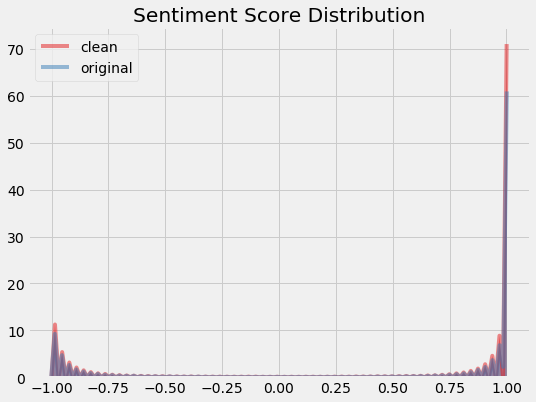

In [54]:
# check the difference
f, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))
c1, c2 = sns.color_palette('Set1', 2)
sns.kdeplot(scores, shade=True, color=c1, label='clean', alpha=0.5, ax=ax)
sns.kdeplot(scores_d, shade=True, color=c2, label='original', alpha=0.5, ax=ax)
ax.set_title('Sentiment Score Distribution')

There is not so much difference on scores between original posts and processed ones. We choose the processed ones as a feature

In [71]:
mbti['Sentiment'] = scores

### Ellipses count

Counting number of ellipsies used per user.

In [73]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.\|\|\|',posts)) for posts in mbti['posts']]
# Append to dataset 
mbti['Ellipses'] = ellipses_count

### Exclamation count
Counting number of exclamation marks used per user. 

In [74]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Exclamation'] = exclamation_count

### Question count
Counting number of question marks used per user. 

In [75]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Question'] = question_count

### Link count
Counting number of links used per user. 

In [76]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
# Append to dataframe
mbti['Links'] = link_count

### Picture count

In [77]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Picture'] = question_count

### Emojies count
We should probably modify the text_style_emojies to include more.

In [78]:
def find_emoji(text):
    # REMOVE LATER ON
    text = text.lower()
    
    text = re.sub(r'\|\|\|', ' ', text)
    
    slack_style_emojies = re.findall(r':[\w\d]+(\-[\w\d]+)?:', text)
    text_style_emojies = re.findall(r':[\-|\s]?[d|\)|\(|p]', text)
    
    return slack_style_emojies + text_style_emojies

In [79]:
mbti['Emojies'] = mbti['posts'].map(lambda x: len(find_emoji(x)))

### Upper case count

In [80]:
def del_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    return regex.sub("", text)

temp = mbti['posts'].apply(lambda x: del_punct(x))
mbti['Upper'] = temp.apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [81]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var,Sentiment,ellipses,exclamation,question,links,picture,emojies,upper
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900,0.9924,8,3,18,24,6,4,13
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756,0.9987,18,0,5,9,8,14,82
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900,0.9985,13,4,12,4,0,10,26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324,0.9985,23,3,11,2,0,0,57
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576,0.9914,20,1,10,6,2,1,35


## Additional Cleaning
- Naive Bayes doesn't take negative numbers.
- Sentiment Scores have NaNs

In [206]:
# NaNs were found: 
mbti.fillna(value=0, inplace=True)
# Naive Bayes can't handle negatives? Scale with MinMax 
min_max_scaler = MinMaxScaler()
sentiment_scaled = min_max_scaler.fit_transform(np.array(mbti['Sentiment']).reshape(-1, 1))
mbti['Sentiment'] = sentiment_scaled

### Save it

In [207]:
mbti.to_csv("data/mbti_FE.csv",index=False)

# Step3

## Base Model: MultinomialNB & Logistic Regression

In [8]:
mbti = pd.read_csv("data/mbti_FE.csv")

In [26]:
from helperfunctions.PrettyConfusionMatrix import print_cm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
import time
import warnings
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')
from random import choice
import lightgbm as lgb
import gc
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [10]:
types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}

Here we set a function to collect models' performances on roc

In [18]:
def average_roc(probabilities):
    '''
    Calculates average ROC curves over n_splits of stratified shuffle splits. Not all thresholds
    are chosen equally, thus different splits have different array lengths of FPR and TPR. In 
    order to average we need the same array length. We will interpolate tpr values between 0 and 1
    in 0.1 increments. This gives an average of a set of *estimated* ROC curves. 

    Function returns a dictionary with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'.  
    Within each class value contains another dictionary with keys 'base_fpr', 'est_tpr', and 'auc'
    'est_tpr' is the average TPR across all splits and 'auc' is the average AUC across all splits.
    '''
    avg_roc = defaultdict() 
    base_fpr = np.linspace(0,1,101)

    for types in probabilities.keys():
        avg_roc[types] = {'base_fpr':base_fpr, 'est_tpr':np.zeros(101), 'auc':[]} 
        total_splits = len(probabilities[types]) 
        for split in probabilities[types]:
            y_scores = split[0] # split[0] is the model probability of predicting a 1
            y_true = split[1] # split[1] is the true test values for that split
            fpr, tpr, thresholds = roc_curve(y_true,y_scores) # used for interpolation
            avg_roc[types]['est_tpr'] += np.interp(base_fpr, fpr, tpr) # Add est_tpr 
            avg_roc[types]['auc'].append(auc(fpr, tpr)) # Append AUC 
        avg_roc[types]['est_tpr'] = avg_roc[types]['est_tpr'] / total_splits # Average TPRs 
        avg_roc[types]['auc'] = np.mean(avg_roc[types]['auc']) # Average AUCs 
        
    return avg_roc

In [27]:
def model(model, X, target, nsplits=4):
    '''
    Estimates probabilities for observations being in class 1.

    Function feeds total probabilities into average ROC. Total probabilities is a dictionary 
    with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'. Within each class value contains a 
    list of probabilities for each split.

    Example: total_probabilities['EorI'] contains [[p1,p2,p3...],[p1,p2,p3...],...]
    '''
    
    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)
    total_probabilities = defaultdict()

    t = time.time()
    for col in target.columns:
        print(f"* {types[col]} ")
        y = target[col]
        all_auc = []
        all_accuracies = []
        f_score = []
        total_probabilities[col] = []
        for train, test in kf.split(X, y):
            X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y[train], y[test]
            model.fit(X_train, y_train)
            probabilities = model.predict_proba(X_test)
            score = probabilities[:, 1]
            preds = model.predict(X_test)
            total_probabilities[col].append((score, y_test))
            all_auc.append(roc_auc_score(y_test,score))
#             all_accuracies.append(accuracy_score(y_test,preds))
            fscore = f1_score(preds,y_test)
            f_score.append(fscore)
        print_cm(confusion_matrix(y_test, preds,[1,0]),['1','0'])
        print(f'Average AUC: {np.mean(all_auc):.3f}; Average fscore: {np.mean(f_score):.3f}')
#         print_cm(confusion_matrix(y_test, preds,[1,0]),['1','0']) # prints last split only
    print(f"Time use:{time.time()-t:.3f}s")

    return average_roc(total_probabilities)

In [28]:
# initialize
MNB = MultinomialNB()
LR = LogisticRegression(random_state=0)
target = mbti.iloc[:,2:6]

X_tf = pd.concat([mbti.iloc[:,6:],word_tfidf_df],axis=1)
X_ct = pd.concat([mbti.iloc[:,6:],word_ct_df],axis=1)

In [29]:
mnb_tf_model = model(MNB, X_tf, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  75.0 125.0 
        0 171.0 497.0 
Average AUC: 0.599; Average fscore: 0.348
* Intuition vs. Sensing 
              1     0 
        1  37.0  83.0 
        0 151.0 597.0 
Average AUC: 0.557; Average fscore: 0.217
* Thinking vs. Feeling 
              1     0 
        1 278.0 120.0 
        0 202.0 268.0 
Average AUC: 0.682; Average fscore: 0.641
* Judging vs. Perceiving 
              1     0 
        1 329.0 195.0 
        0 194.0 150.0 
Average AUC: 0.561; Average fscore: 0.643
Time use:2.932s


In [30]:
lr_tf_model = model(LR, X_tf, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  33.0 167.0 
        0  22.0 646.0 
Average AUC: 0.751; Average fscore: 0.259
* Intuition vs. Sensing 
              1     0 
        1   3.0 117.0 
        0   2.0 746.0 
Average AUC: 0.745; Average fscore: 0.045
* Thinking vs. Feeling 
              1     0 
        1 303.0  95.0 
        0  72.0 398.0 
Average AUC: 0.867; Average fscore: 0.765
* Judging vs. Perceiving 
              1     0 
        1 436.0  88.0 
        0 205.0 139.0 
Average AUC: 0.708; Average fscore: 0.756
Time use:43.792s


In [31]:
mnb_ct_model = model(MNB, X_ct, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1 109.0  91.0 
        0 161.0 507.0 
Average AUC: 0.709; Average fscore: 0.451
* Intuition vs. Sensing 
              1     0 
        1  60.0  60.0 
        0 163.0 585.0 
Average AUC: 0.700; Average fscore: 0.357
* Thinking vs. Feeling 
              1     0 
        1 305.0  93.0 
        0 137.0 333.0 
Average AUC: 0.812; Average fscore: 0.730
* Judging vs. Perceiving 
              1     0 
        1 360.0 164.0 
        0 164.0 180.0 
Average AUC: 0.647; Average fscore: 0.686
Time use:3.126s


In [32]:
lr_ct_model = model(LR, X_ct, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  80.0 120.0 
        0 104.0 564.0 
Average AUC: 0.700; Average fscore: 0.423
* Intuition vs. Sensing 
              1     0 
        1  34.0  86.0 
        0  78.0 670.0 
Average AUC: 0.675; Average fscore: 0.294
* Thinking vs. Feeling 
              1     0 
        1 292.0 106.0 
        0 119.0 351.0 
Average AUC: 0.808; Average fscore: 0.714
* Judging vs. Perceiving 
              1     0 
        1 376.0 148.0 
        0 178.0 166.0 
Average AUC: 0.672; Average fscore: 0.715
Time use:59.346s


Notice the great gap between AUC and accuracy in EorI, IorS, both of which are unbalanced. But we can deal with it in the following models.

### Random Forest

In [38]:
random_forest = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=7)

In [39]:
rf_ct_model = model(random_forest, X_ct, target, nsplits=4)

* Extroversion vs. Introversion 
              1     0 
        1   0.0 200.0 
        0   0.0 668.0 
Average AUC: 0.707; Average fscore: 0.000
* Intuition vs. Sensing 
              1     0 
        1   0.0 120.0 
        0   0.0 748.0 
Average AUC: 0.681; Average fscore: 0.000
* Thinking vs. Feeling 
              1     0 
        1 226.0 172.0 
        0  50.0 420.0 
Average AUC: 0.819; Average fscore: 0.643
* Judging vs. Perceiving 
              1     0 
        1 524.0   0.0 
        0 344.0   0.0 
Average AUC: 0.669; Average fscore: 0.753
Time use:98.527s


In [40]:
rf_tf_model = model(random_forest, X_tf, target, nsplits=4)

* Extroversion vs. Introversion 
              1     0 
        1   0.0 200.0 
        0   0.0 668.0 
Average AUC: 0.717; Average fscore: 0.000
* Intuition vs. Sensing 
              1     0 
        1   0.0 120.0 
        0   0.0 748.0 
Average AUC: 0.686; Average fscore: 0.000
* Thinking vs. Feeling 
              1     0 
        1 236.0 162.0 
        0  51.0 419.0 
Average AUC: 0.826; Average fscore: 0.662
* Judging vs. Perceiving 
              1     0 
        1 524.0   0.0 
        0 343.0   1.0 
Average AUC: 0.677; Average fscore: 0.753
Time use:199.911s


## Advanced Model: Xgboost & Lightgbm

### Xgboost

In [41]:
XGB = XGBClassifier(eval_metric='auc')

In [42]:
xgb_ct_model = model(XGB, X_ct, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  19.0 181.0 
        0   7.0 661.0 
Average AUC: 0.716; Average fscore: 0.137
* Intuition vs. Sensing 
              1     0 
        1   0.0 120.0 
        0   0.0 748.0 
Average AUC: 0.682; Average fscore: 0.013
* Thinking vs. Feeling 
              1     0 
        1 281.0 117.0 
        0  82.0 388.0 
Average AUC: 0.830; Average fscore: 0.725
* Judging vs. Perceiving 
              1     0 
        1 475.0  49.0 
        0 259.0  85.0 
Average AUC: 0.693; Average fscore: 0.763
Time use:313.483s


In [43]:
xgb_tf_model = model(XGB, X_tf, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  19.0 181.0 
        0  10.0 658.0 
Average AUC: 0.716; Average fscore: 0.131
* Intuition vs. Sensing 
              1     0 
        1   2.0 118.0 
        0   0.0 748.0 
Average AUC: 0.685; Average fscore: 0.016
* Thinking vs. Feeling 
              1     0 
        1 288.0 110.0 
        0  85.0 385.0 
Average AUC: 0.836; Average fscore: 0.728
* Judging vs. Perceiving 
              1     0 
        1 463.0  61.0 
        0 236.0 108.0 
Average AUC: 0.695; Average fscore: 0.760
Time use:414.132s


### LightGBM

In [44]:
LGB = lgb.LGBMClassifier(eval_metric='auc')

In [45]:
lgb_ct_model = model(LGB, X_ct, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  30.0 170.0 
        0  21.0 647.0 
Average AUC: 0.722; Average fscore: 0.237
* Intuition vs. Sensing 
              1     0 
        1   3.0 117.0 
        0   4.0 744.0 
Average AUC: 0.685; Average fscore: 0.066
* Thinking vs. Feeling 
              1     0 
        1 285.0 113.0 
        0  88.0 382.0 
Average AUC: 0.844; Average fscore: 0.734
* Judging vs. Perceiving 
              1     0 
        1 449.0  75.0 
        0 220.0 124.0 
Average AUC: 0.688; Average fscore: 0.752
Time use:58.064s


In [46]:
lgb_tf_model = model(LGB, X_tf, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1  32.0 168.0 
        0  22.0 646.0 
Average AUC: 0.729; Average fscore: 0.241
* Intuition vs. Sensing 
              1     0 
        1   4.0 116.0 
        0   3.0 745.0 
Average AUC: 0.679; Average fscore: 0.053
* Thinking vs. Feeling 
              1     0 
        1 295.0 103.0 
        0  92.0 378.0 
Average AUC: 0.851; Average fscore: 0.742
* Judging vs. Perceiving 
              1     0 
        1 436.0  88.0 
        0 223.0 121.0 
Average AUC: 0.687; Average fscore: 0.749
Time use:200.372s


Lightgbm performs a bit better than xgboost in terms of AUC and Accuracy and saves much more time. Besides, Lightgbm running on tfidf vectors outperforms a little bit. I decide to go further on lightgbm and dataset containing tfidf vectors(X_tf).

### Random Search
- iteration=20 takes nearly 25mins to run

In [15]:
kf = StratifiedShuffleSplit(n_splits=5, random_state=420)

# loop for random search
n_iterations=20

print ("Random search start...")
for col in target.columns:
    print(f"* {types[col]} ")
    y = target[col]
    roc_auc_mean = []
    dict_list = []
    for i in range(0, n_iterations):

        param_dist = {'n_estimators' : choice([250,300,350,400,450]),
                  'bagging_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                  'learning_rate': choice([0.05, 0.1, 0.3, 0.5]),
                  'is_unbalance': True,
                  'max_bin': choice([3, 5, 10, 15, 18, 20, 25]),
                  'boosting_type' : choice(['gbdt', 'dart']),
                  'max_depth': choice([2,3,4,5]),      
                  'feature_fraction': choice([0.7, 0.8, 0.9]),
                  'lambda_l1': choice([0, 10, 20, 30, 40]),
                  'objective': 'binary', 
                  'metric': 'auc'} 

        roc_l = []

        for train, test in kf.split(X_tf,y):

            X_train, X_test, y_train, y_test = X_tf.loc[train], X_tf.loc[test], y[train], y[test]

            # training
            gbm = lgb.LGBMClassifier(**param_dist)
            gbm.fit(X_train,y_train)
            # predicting
            y_pred = np.round(gbm.predict_proba(X_test)[:,1],3)
            roc = roc_auc_score(y_test, y_pred)
            roc_l.append(roc)

        roc_array = np.asarray(roc_l)

        roc_auc_mean.append(roc_array.mean())
        dict_list.append(param_dist)
        gc.collect()

    results_pd = pd.DataFrame({"roc_auc_mean": roc_auc_mean,"parameters": dict_list})    

    results_pd.sort_values("roc_auc_mean", ascending = False, axis = 0, inplace = True)
    top_pd = results_pd.head(1)
    print(f"--> Best AUC:{top_pd.iloc[0,0]} using {top_pd.iloc[0,1]}")

Random search start...
* Extroversion vs. Introversion 
--> Best AUC:0.7323989520958085 using {'n_estimators': 400, 'bagging_fraction': 0.8, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.7, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'}
* Intuition vs. Sensing 
--> Best AUC:0.7228598484848485 using {'n_estimators': 350, 'bagging_fraction': 0.5, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 15, 'boosting_type': 'gbdt', 'max_depth': 4, 'feature_fraction': 0.9, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'}
* Thinking vs. Feeling 
--> Best AUC:0.8532513631989737 using {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'}
* Judging vs. Perceiving 
--> Best AUC:0.6998185913367655 using {'n_estimators': 250, 'bagging

In [51]:
def treemodel(X, target, nsplits=4):
    '''
    Estimates probabilities for observations being in class 1.

    Function feeds total probabilities into average ROC. Total probabilities is a dictionary 
    with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'. Within each class value contains a 
    list of probabilities for each split.

    Example: total_probabilities['EorI'] contains [[p1,p2,p3...],[p1,p2,p3...],...]
    '''

    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)
    total_probabilities = defaultdict()
#     this is for lgb
    para_list = [{'n_estimators': 400, 'bagging_fraction': 0.8, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.7, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 350, 'bagging_fraction': 0.5, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 15, 'boosting_type': 'gbdt', 'max_depth': 4, 'feature_fraction': 0.9, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 10, 'objective': 'binary', 'metric': 'auc'}]
    # this is for rf
#     para_list = [{'n_estimators': 1525, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False},
#              {'n_estimators': 575, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False},
#              {'n_estimators': 1525, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False},
#              {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}]
    
    
    t = time.time()
    for i,col in enumerate(target.columns):
        print(f"* {types[col]} ")
        param = para_list[i]
        
        y = target[col]
        all_auc = []
#         all_accuracies = []
        f_score = []
        total_probabilities[col] = []
        for train, test in kf.split(X, y):
            X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y[train], y[test]
            
            
            gbm = lgb.LGBMClassifier(**param)
            gbm.fit(X_train,y_train)
#             rf = RandomForestClassifier(**param)
#             rf.fit(X_train,y_train)
            # predicting
            probabilities = gbm.predict_proba(X_test)
            preds = gbm.predict(X_test)
#             probabilities = rf.predict_proba(X_test)
            score = probabilities[:, 1]
#             preds = model.predict(X_test)
            total_probabilities[col].append((score, y_test))
            all_auc.append(roc_auc_score(y_test,score))
#             all_accuracies.append(accuracy_score(y_test,preds))
            
            fscore = f1_score(preds,y_test)
            f_score.append(fscore)
        print_cm(confusion_matrix(y_test, preds,[1,0]),['1','0'])
        print(f'Average AUC: {np.mean(all_auc):.3f}; Average fscore: {np.mean(f_score):.3f}')
    print(f"Time use:{time.time()-t:.3f}s")

    return average_roc(total_probabilities)

In [53]:
lgb_tf_model_t = treemodel(X_tf, target, nsplits=5)

* Extroversion vs. Introversion 
              1     0 
        1 128.0  72.0 
        0 178.0 490.0 
Average AUC: 0.732; Average fscore: 0.478
* Intuition vs. Sensing 
              1     0 
        1  51.0  69.0 
        0 138.0 610.0 
Average AUC: 0.723; Average fscore: 0.355
* Thinking vs. Feeling 
              1     0 
        1 306.0  92.0 
        0  99.0 371.0 
Average AUC: 0.853; Average fscore: 0.760
* Judging vs. Perceiving 
              1     0 
        1 362.0 162.0 
        0 137.0 207.0 
Average AUC: 0.701; Average fscore: 0.713
Time use:94.475s


# Plotting ROC

In [56]:
def plot_avg_roc(model_list, model_names):
    '''
    From model list and model names, plots ROC curves for each class on a 2x2 grid.
    Add more colors to colors list if number of model exceeds current list length.
    '''
    fig, axs = plt.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='b')
    axs = axs.flatten()
    abbrev = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                     'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
    colors = ['b','g','c','m','y']

    for x in range(len(model_list)):
        roc_data = model_list[x]
        types = list(roc_data.keys())

        for i in range(len(types)):
            base_fpr = roc_data[types[i]]['base_fpr']
            est_tpr = roc_data[types[i]]['est_tpr']
            auc = roc_data[types[i]]['auc']
            axs[i].plot(base_fpr, est_tpr, colors[x], linewidth=1, label = '%s = %0.2f' %(model_names[x], auc))
            axs[i].plot([0, 1], [0, 1],'r--', linewidth = 1)
            axs[i].legend(loc = 'lower right', title = 'Avg AUC Scores')
            axs[i].set_xlim([0, 1])
            axs[i].set_ylim([0, 1])
            axs[i].set_ylabel('True Positive Rate')
            axs[i].set_xlabel('False Positive Rate')
            axs[i].set_title('ROC for %s'  % abbrev[types[i]])

In [58]:
model_list = [lr_tf_model, lgb_tf_model_t, xgb_tf_model, mnb_ct_model,rf_tf_model] # 4 best models
model_names = ['LR TFIDF', 'LGB TFIDF tuned','XGB TFIDF', 'MNB Word ct','RF TFIDF']

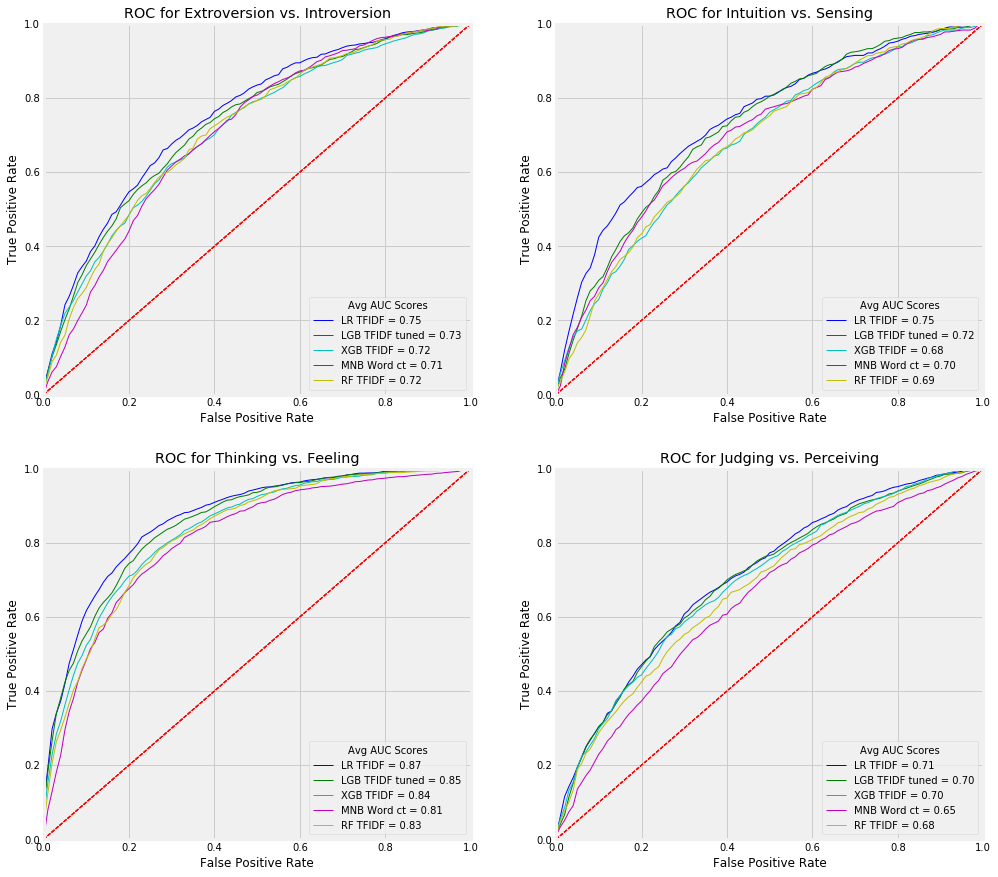

In [59]:
plot_avg_roc(model_list, model_names)

In terms of ROC, Logistic regression model performs the best.

### Additional things to Consider:

- How to explain EorI things to the auidence in an easy way
- add pca
- others....